## Task 2: Decision and Walkthrough of Model

In this task, we need to construct a model to analyze the correlation between spatial features and temporal features of storm images and wind speed. Additionally, we aim to explore predicting future wind speeds by leveraging spatial features and their variations.

We had a few choice to make, based on the data we have there are roughly three approaches available for us to establish a model:

- utilizing only image features as input and employing networks like CNN, ResNet, etc., to train the model. Improvements in model performance can be achieved through techniques such as transfer learning or training specifically for a given dataset. This approach is easy to train, with straightforward and simple code. However, the optimal RMSE (Root Mean Square Error) seems to plateau at around 8, making it challenging to make further improvements.

- Adopting models that combine time series, such as ConvLSTM. This approach has been proven to exhibit better performance in our experiments and has been chosen as the final solution.

- 💡**Innovation**💡: Using time-correlated image features as input and regressing wind speed through CNN or other networks. Inspired by the winners of the competition, I attempted to stack three consecutive timestamped images, creating a three-channel image as the input for the model. And then I took it a step further by incorporating the actual wind speed of the first image among the three consecutive timestamps as an additional channel, forming a four-channel input image in matrix form. This addition aimed to introduce a trend in the input data beyond temporal correlation, ultimately enhancing the model's performance.

Here is the walkthrough for the third option, which ultimately became our choice.

In [1]:
%matplotlib inline

In [2]:
import os
import json
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, ConcatDataset, DataLoader, Subset, random_split
from torchvision.transforms import ToTensor
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from livelossplot import PlotLosses

In [3]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f'Using device: {device}')

Using device: mps


In [4]:
class StormDataset(Dataset):
    def __init__(self, root_dir, start_idx=0, end_idx=None, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data_path = sorted([file for file in os.listdir(root_dir) if file.endswith('.jpg')])[start_idx:end_idx]

    def __len__(self):
        return len(self.data_path) - 2

    def __getitem__(self, idx):
        img1 = Image.open(os.path.join(self.root_dir, self.data_path[idx])).convert('L')
        img2 = Image.open(os.path.join(self.root_dir, self.data_path[idx+1])).convert('L')
        img3 = Image.open(os.path.join(self.root_dir, self.data_path[idx+2])).convert('L')

        # Image transformation
        img1 = self.transform(img1)
        img2 = self.transform(img2)
        img3 = self.transform(img3)

        label1_path = os.path.join(self.root_dir, self.data_path[idx+2].replace('.jpg', '_label.json'))
        label3_path = os.path.join(self.root_dir, self.data_path[idx+2].replace('.jpg', '_label.json'))
        with open(label1_path, 'r') as f:
            label1 = json.load(f)['wind_speed']
        with open(label3_path, 'r') as f:
            label3 = json.load(f)['wind_speed']

        # Combine images into a 4-channel tensor
        eye_tensor = torch.eye(128).unsqueeze(0)
        stacked_img = torch.cat([float(label1)*eye_tensor, img1, img2, img3], dim=0)

        # Load targer to this stacked_img
        target = torch.tensor(float(label3))

        return stacked_img, target

data_path = '/Users/zz2123/Documents/Selected_Storms_curated/tst/'

transformer = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

dataset = StormDataset(root_dir=data_path, start_idx=0, end_idx=-20, transform=transformer)

# 划分训练集和验证集
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [5]:
len(dataset)

230

In [6]:
# 定义ConvNet模型
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Flatten()
        )
        self.linear_layer = nn.Sequential(
            nn.Linear(64*128*128, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.linear_layer(x)
        return x

# Instantiate the model
model = ConvNet().to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 10
model.to(device)

ConvNet(
  (conv_layer): Sequential(
    (0): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Dropout(p=0.5, inplace=False)
    (5): Flatten(start_dim=1, end_dim=-1)
  )
  (linear_layer): Sequential(
    (0): Linear(in_features=1048576, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [7]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    liveplot = PlotLosses()
    best_val_loss = 200
    for epoch in range(num_epochs):
        model.train()
        train_iterator = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', dynamic_ncols=True)
        train_loss = 0.0
        for inputs, labels in train_iterator:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_iterator.set_postfix({'Train Loss': loss.item()}, refresh=True)

        # 在验证集上评估模型
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels.unsqueeze(1).float()).item()
        
        train_loss /=len(train_loader)
        val_loss /= len(val_loader)
        liveplot.update({
            'loss': train_loss,
            'val_loss': val_loss
        })
        liveplot.draw()

        # Save the model if it has the best validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model_tst_v5.0.pth')

        print(f'Validation Loss: {val_loss}')

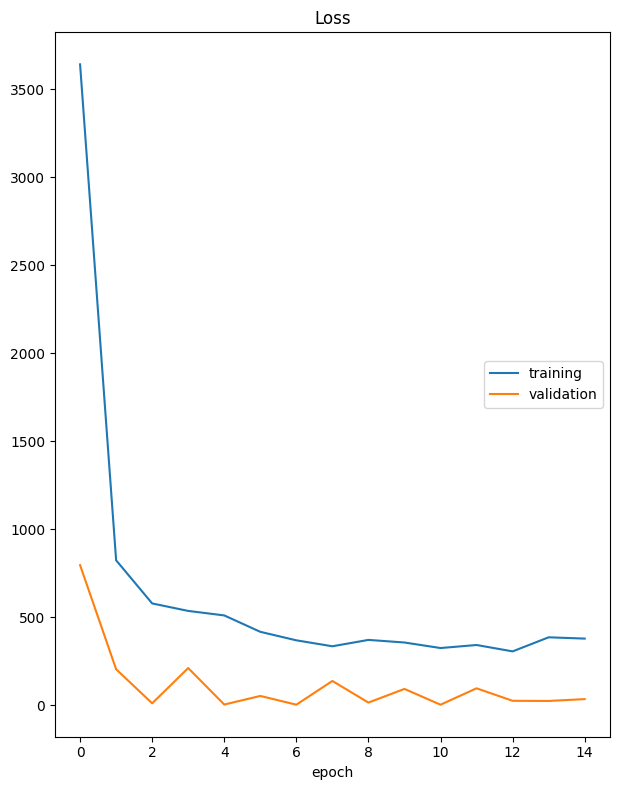

Loss
	training         	 (min:  305.072, max: 3642.029, cur:  377.790)
	validation       	 (min:    1.986, max:  795.257, cur:   33.727)
Validation Loss: 33.72720718383789


In [8]:
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=15)

In [9]:
def predict(model, data_loader, device):
    model.eval()  # 设置模型为评估模式
    predictions = []

    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            flattened_outputs = outputs.view(-1).cpu().numpy()  # 展平后转换为 numpy 数组
            predictions.extend(flattened_outputs)

    return predictions

rmse: 0.6859115176811763


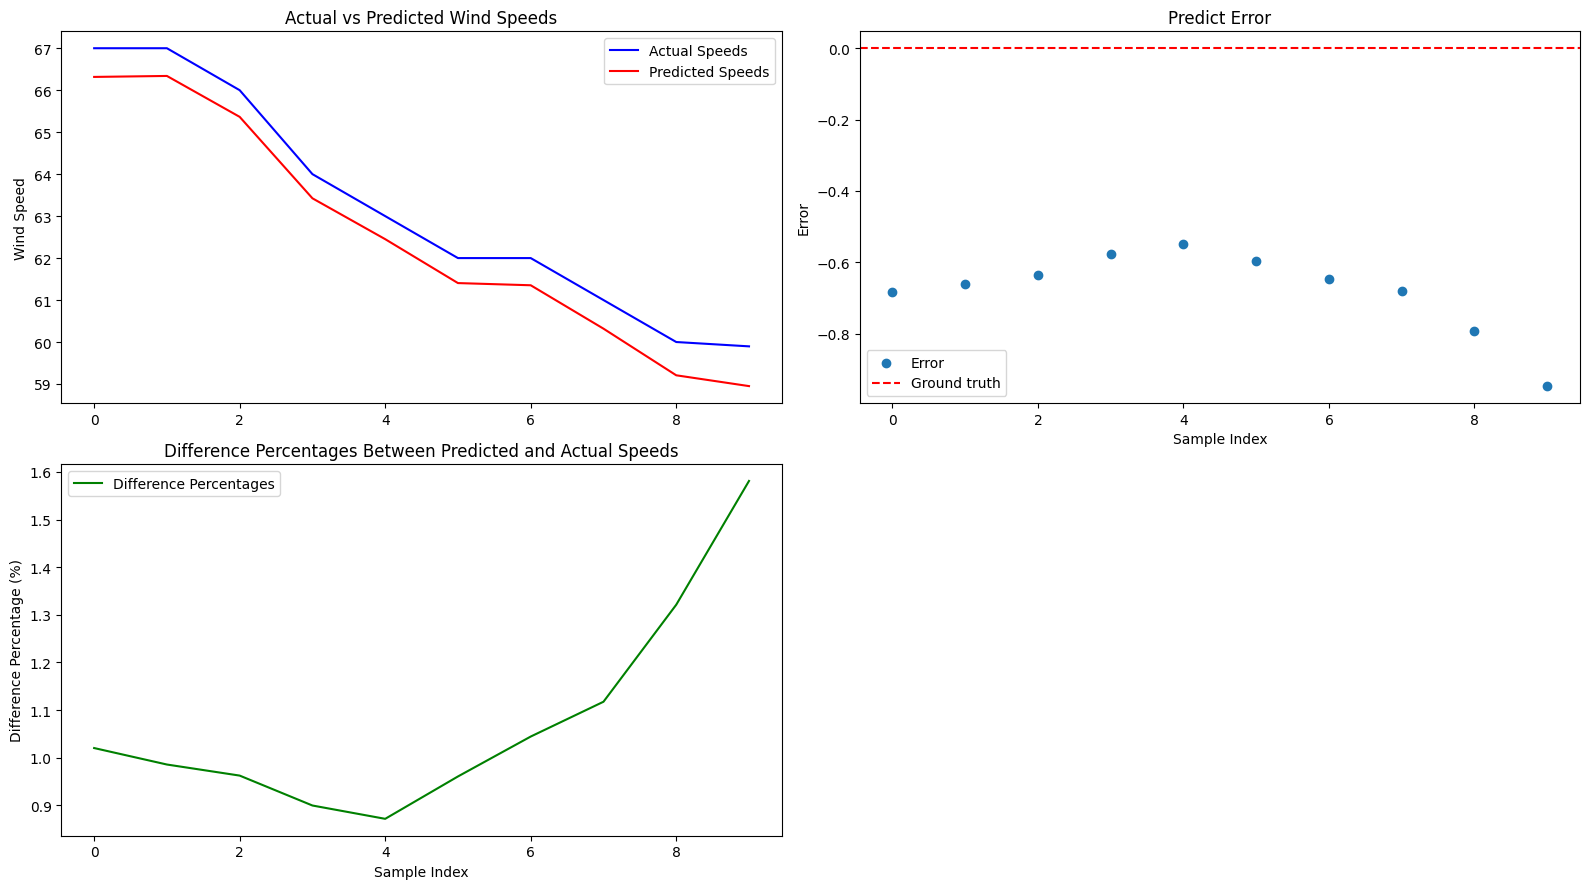

In [14]:
def load_wind_speed(json_path):
    with open(json_path, 'r') as file:
        data = json.load(file)
        return float(data['wind_speed'])
    
def show_predict_result(unseen_path, model):
    predicted_speeds = []
    actual_speeds = []

    predict_loader = DataLoader(StormDataset(root_dir=unseen_path, start_idx=-22, end_idx=-10, transform=transformer), batch_size=32, shuffle=False)
    predicted_speeds = predict(model, predict_loader, device)

    json_path = [f for f in os.listdir(unseen_path) if f.endswith('_label.json')]
    json_path.sort()

    # Loop through the folder
    for file in json_path[-10:]:
        # Load actual wind speed
        actual_speed = load_wind_speed(os.path.join(unseen_path, file))
        actual_speeds.append(actual_speed)
    
    # Calculate differences and difference percentages
    differences = np.array(predicted_speeds) - np.array(actual_speeds)
    difference_percentages = np.abs(differences) / np.array(actual_speeds) * 100

    rmse = np.sqrt(np.mean(np.square(differences)))
    print('rmse:',rmse)
    # Plotting
    plt.figure(figsize=(16, 9))
    plt.subplot(2, 2, 1)
    plt.plot(actual_speeds, label='Actual Speeds', color='blue')
    plt.plot(predicted_speeds, label='Predicted Speeds', color='red')
    plt.ylabel('Wind Speed')
    plt.title('Actual vs Predicted Wind Speeds')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(difference_percentages, label='Difference Percentages', color='green')
    plt.xlabel('Sample Index')
    plt.ylabel('Difference Percentage (%)')
    plt.title('Difference Percentages Between Predicted and Actual Speeds')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.scatter(range(len(differences)), differences, label='Error')
    plt.axhline(y=0, color='red', linestyle='--', label='Ground truth')
    plt.xlabel('Sample Index')
    plt.ylabel('Error')
    plt.title('Predict Error')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Folder containing the images and JSON files
pretrained_model = ConvNet().to(device)
pretrained_model.load_state_dict(torch.load('best_model_tst_v5.0.pth'))
unseen_path = '/Users/zz2123/Documents/Selected_Storms_curated/tst/'
show_predict_result(unseen_path, pretrained_model)

In [17]:
def process_files(folder_path, model):
    # 获取文件夹中的所有文件
    img_files = [img for img in sorted(os.listdir(folder_path)) if img.endswith('.jpg')]
    json_files = [img.replace('.jpg', '_label.json') for img in img_files]
    
    for i in range(13):
        img1 = Image.open(os.path.join(folder_path, img_files[i+240])).convert('L')
        img2 = Image.open(os.path.join(folder_path, img_files[i+241])).convert('L')
        img3 = Image.open(os.path.join(folder_path, img_files[i+242])).convert('L')

        # Image transformation
        img1 = transformer(img1)
        img2 = transformer(img2)
        img3 = transformer(img3)

        label1_path = os.path.join(folder_path, json_files[i+240])
        label3_path = os.path.join(folder_path, json_files[i+242])
        with open(label1_path, 'r') as f:
            label1 = json.load(f)['wind_speed']

        # Combine images into a 4-channel tensor
        eye_tensor = torch.eye(128).unsqueeze(0)
        inputs = torch.cat([float(label1)*eye_tensor, img1, img2, img3], dim=0)

        model.eval()
        inputs = inputs.to(device)
        outputs = model(inputs.unsqueeze(0))
        print(outputs.item())
        new_data = {
            'wind_speed': outputs.item(),
            # 其他属性...
        }
        
        # 写入新的json文件
        with open(label3_path, 'w') as new_json:
            json.dump(new_data, new_json, indent=4)

# 调用函数并传入文件夹路径
unseen_path = '/Users/zz2123/Documents/Selected_Storms_curated/tst/'
process_files(unseen_path, pretrained_model)


58.829345703125
58.60569763183594
57.43342590332031
57.087379455566406
55.900245666503906
55.54886245727539
54.43729782104492
54.10373306274414
53.07384490966797
52.82848358154297
52.279701232910156
52.375877380371094
50.962554931640625
